In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

In [13]:
import os
import datetime
import math

import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

from src.utils.fileutils import get_project_root
from src.data.annotations import load_dataset_annotations
from src.data.annotations import make_continious_labels, dense_to_events, single_track_labels
from src.visualization.events import plot_events, plot_single_track_labels, plot_multitrack_labels
from src.data.annotations import class_color_map


In [5]:
project_root = get_project_root()

In [71]:

annotations = load_dataset_annotations().sort_index(level=(0, 1))
annotations.head(3)

skipping archive
skipping MAESTRO_annotation_notes.md
skipping archive
skipping TUT_annotation_notes.md


start     end        annotation annotator
dataset clip               index                                            
maestro cafe_restaurant_08 0       8.685  11.791  Background music        BD
                           1       9.482  10.139          Doorbell        BD
                           2      10.728  10.991              Slam        BD

In [19]:
from src.data.annotations import load_noise_classes

m = load_noise_classes()
m.noise.value_counts()

other           37
speech          16
road_traffic    11
biophony         5
rail_traffic     4
geophony         4
music            2
Name: noise, dtype: int64

In [51]:
# Load from files
soundlevels = pandas.read_parquet(os.path.join(project_root, 'data/processed/soundlevels/LAS.parquet')).droplevel(0).sort_index(level=(0, 1))
soundlevels


level
dataset clip               time                             
maestro cafe_restaurant_08 0 days 00:00:00        -63.619188
                           0 days 00:00:00.250000 -63.452527
                           0 days 00:00:00.500000 -63.202250
                           0 days 00:00:00.750000 -63.457620
                           0 days 00:00:01        -63.813956
...                                                      ...
tut     b093               0 days 00:03:29.500000 -53.015915
                           0 days 00:03:29.750000 -53.112149
                           0 days 00:03:30        -53.103120
                           0 days 00:03:30.250000 -53.007961
                           0 days 00:03:30.500000 -52.817005

[14056 rows x 1 columns]

In [50]:
spectrograms = pandas.read_parquet(os.path.join(project_root, 'data/processed/spectrograms/logmels-64bands-256hop.parquet')).droplevel(0).sort_index(level=(0, 1))
spectrograms


50.0       97.0    \
dataset clip               time                                              
maestro cafe_restaurant_08 0 days 00:00:00            86.776381  75.723411   
                           0 days 00:00:00.005804988  91.017063  77.780982   
                           0 days 00:00:00.011609976  93.746250  77.668488   
                           0 days 00:00:00.017414964  84.935412  58.899572   
                           0 days 00:00:00.023219952  87.768992  71.136857   
...                                                         ...        ...   
tut     b093               0 days 00:03:30.837164160  89.774004  81.986680   
                           0 days 00:03:30.842969148  89.836717  74.044271   
                           0 days 00:03:30.848774136  79.384574  77.476145   
                           0 days 00:03:30.854579124  86.048777  82.674313   
                           0 days 00:03:30.860384112  74.777388  72.692839   

                                                         144.0      191.0   \
dataset clip               time                                              
maestro cafe_restaurant_08 0 days 00:00:00            78.979371  70.969302   
                           0 days 00:00:00.005804988  81.036941  71.714919   
                           0 days 00:00:00.011609976  80.924448  69.565915   
                           0 days 00:00:00.017414964  62.155531  68.790772   
                           0 days 00:00:00.023219952  74.392817  67.219389   
...                                                         ...        ...   
tut     b093               0 days 00:03:30.837164160  85.242640  71.200701   
                           0 days 00:03:30.842969148  77.300231  78.011747   
                           0 days 00:03:30.848774136  80.732105  75.753901   
                           0 days 00:03:30.854579124  85.930273  79.100636   
                           0 days 00:03:30.860384112  75.948799  74.196368   

                                                         238.0      285.0   \
dataset clip               time                                              
maestro cafe_restaurant_08 0 days 00:00:00            72.131066  71.254798   
                           0 days 00:00:00.005804988  72.876683  72.120040   
                           0 days 00:00:00.011609976  70.727678  65.705037   
                           0 days 00:00:00.017414964  69.952536  69.831842   
                           0 days 00:00:00.023219952  68.381152  73.275372   
...                                                         ...        ...   
tut     b093               0 days 00:03:30.837164160  72.362465  78.761275   
                           0 days 00:03:30.842969148  79.173511  70.385901   
                           0 days 00:03:30.848774136  76.915665  73.418990   
                           0 days 00:03:30.854579124  80.262400  64.217977   
                           0 days 00:03:30.860384112  75.358131  75.501810   

                                                         333.0      380.0   \
dataset clip               time                                              
maestro cafe_restaurant_08 0 days 00:00:00            70.450715  70.845578   
                           0 days 00:00:00.005804988  71.315957  62.679720   
                           0 days 00:00:00.011609976  64.900954  67.808840   
                           0 days 00:00:00.017414964  69.027759  69.706135   
                           0 days 00:00:00.023219952  72.471289  70.343213   
...                                                         ...        ...   
tut     b093               0 days 00:03:30.837164160  77.957192  73.285463   
                           0 days 00:03:30.842969148  69.581818  65.226577   
                           0 days 00:03:30.848774136  72.614907  77.720159   
                           0 days 00:03:30.854579124  63.413894  75.004734   
                           0 days 00:03:30.860384112  74.697727  72.629147  

dataset  clip               
maestro  cafe_restaurant_08     None
         cafe_restaurant_10     None
         city_center_09         None
         city_center_11         None
         grocery_store_02       None
         grocery_store_08       None
         metro_station_04       None
         metro_station_05       None
         residential_area_06    None
         residential_area_12    None
tut      a003                   None
         a008                   None
         b005                   None
         b091                   None
         b093                   None
dtype: object

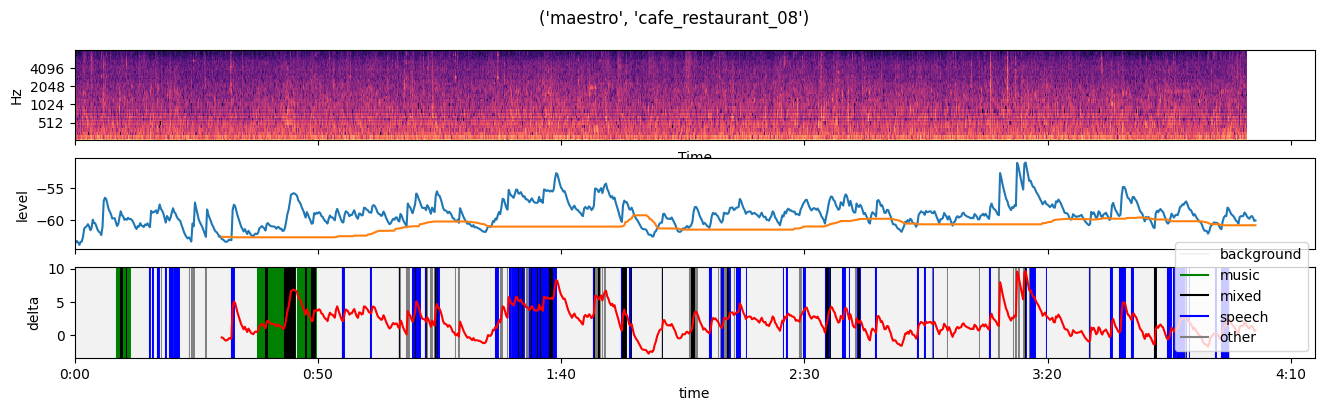

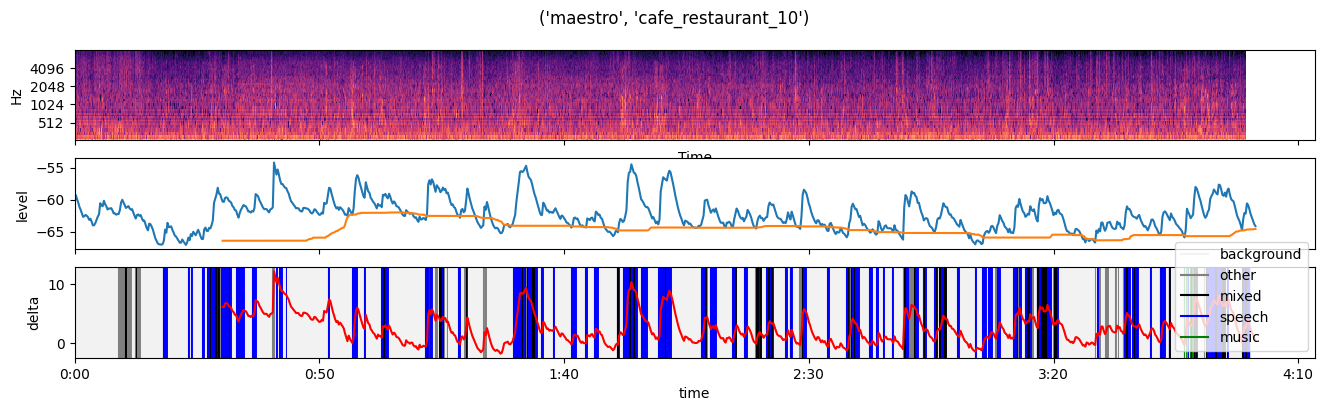

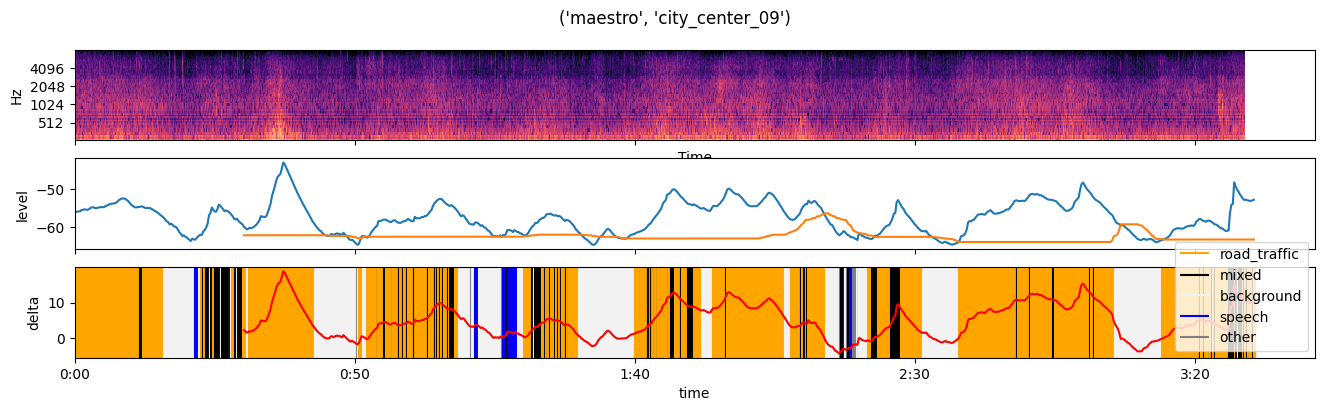

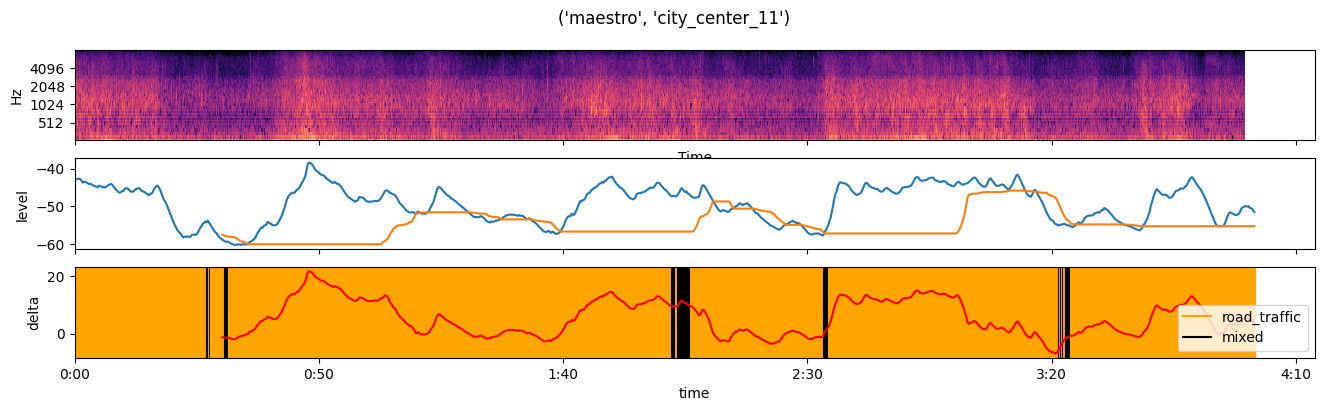

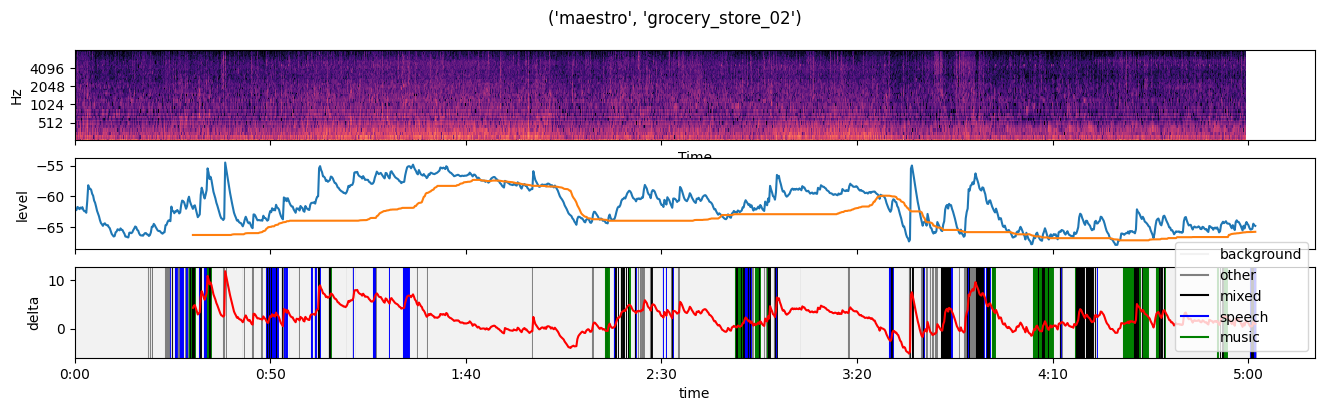

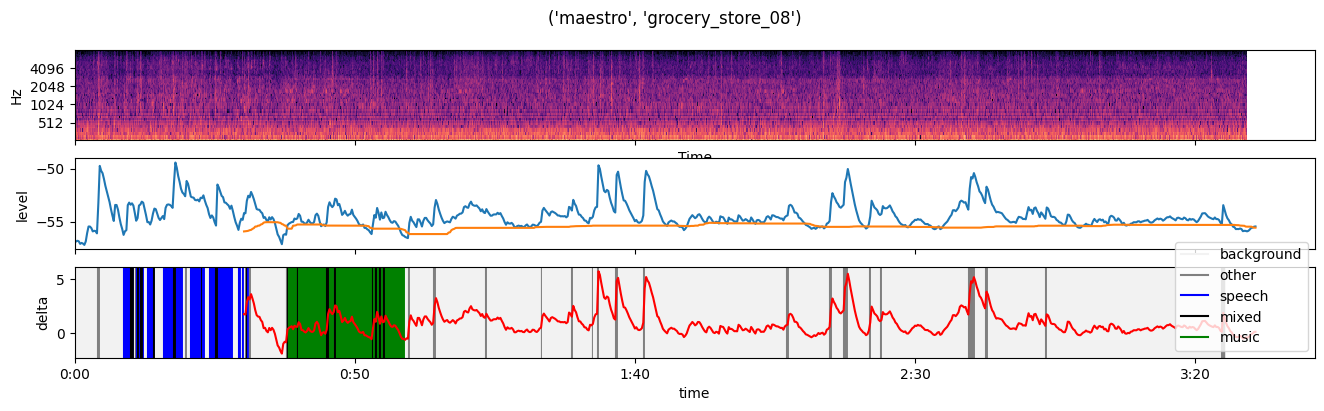

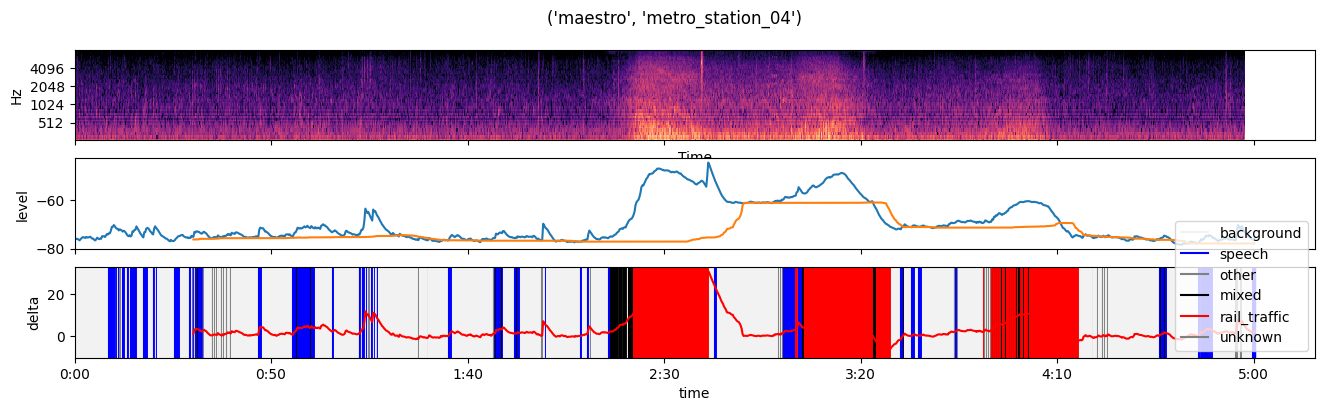

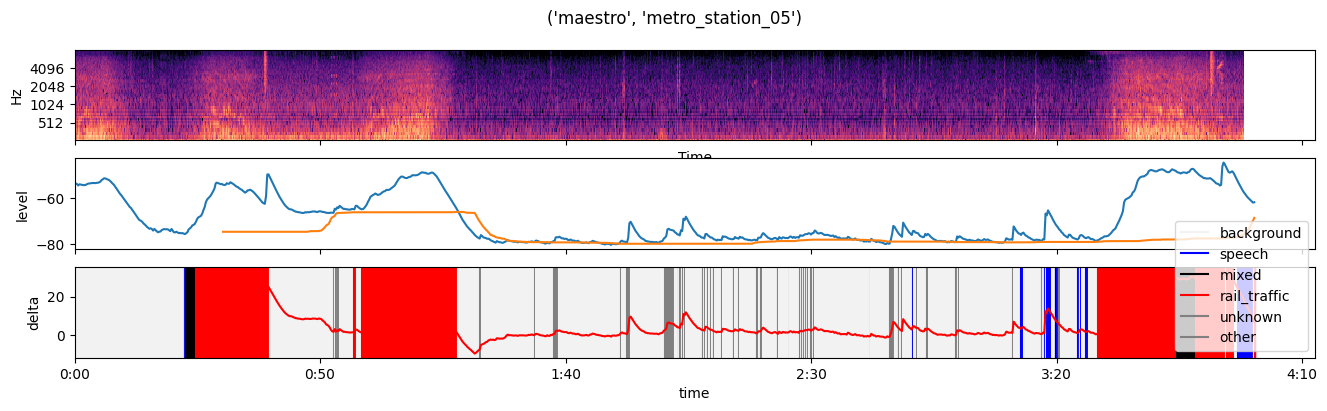

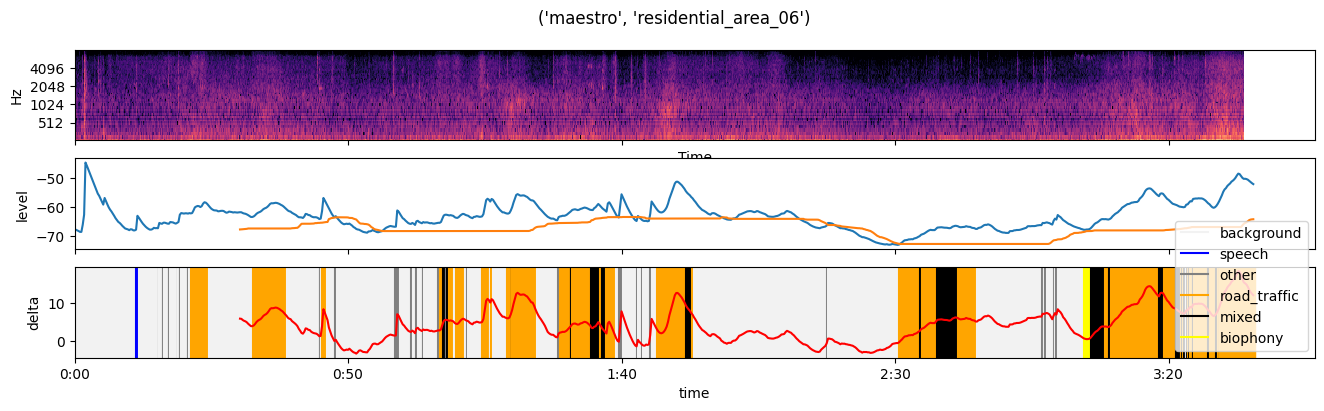

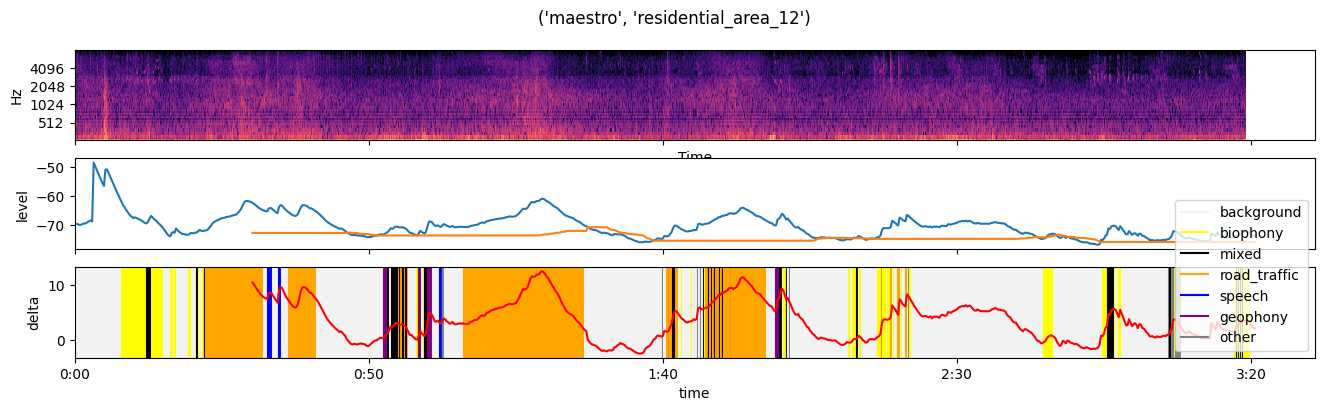

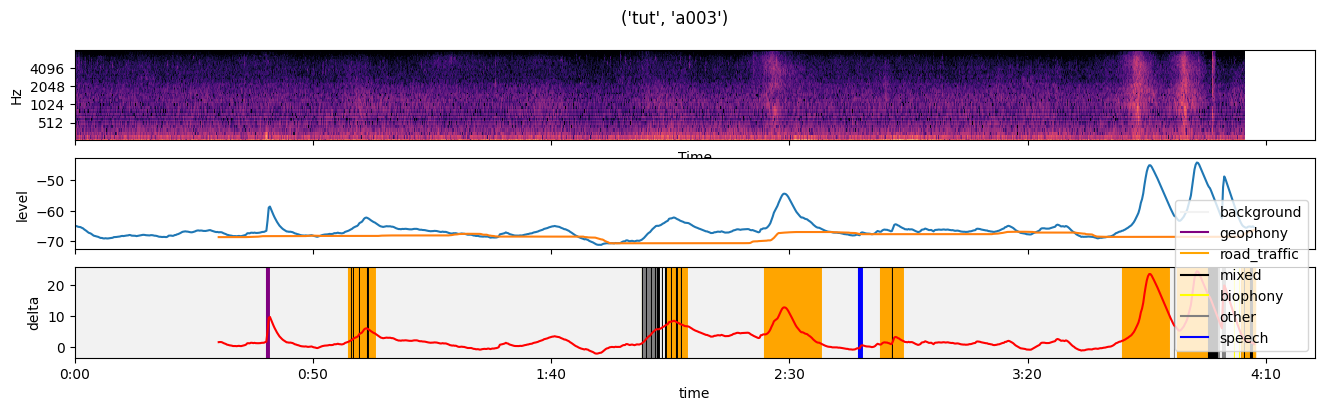

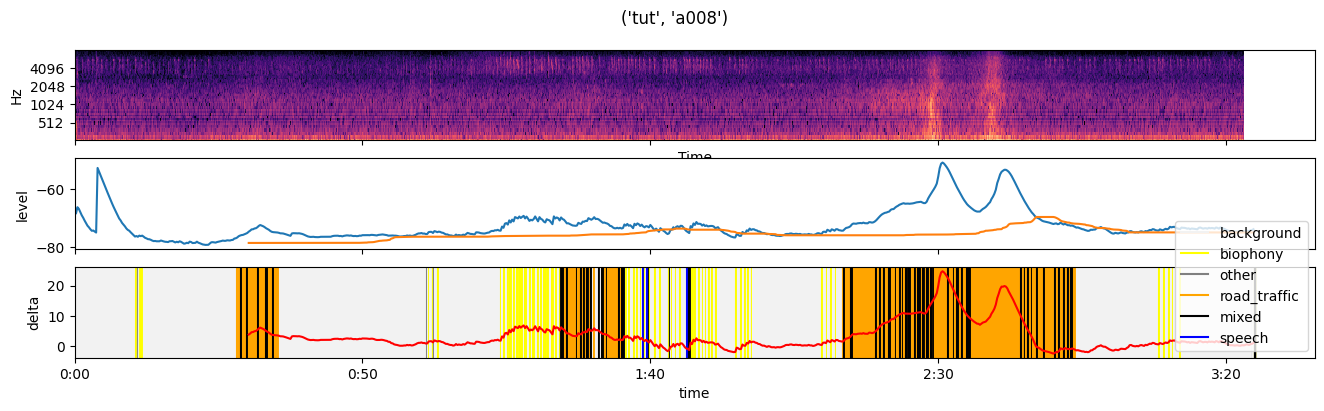

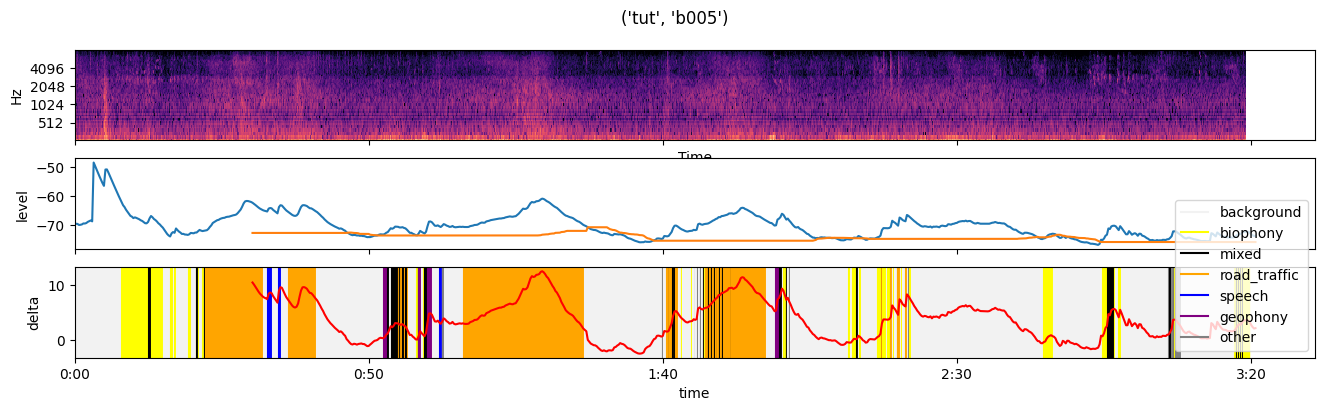

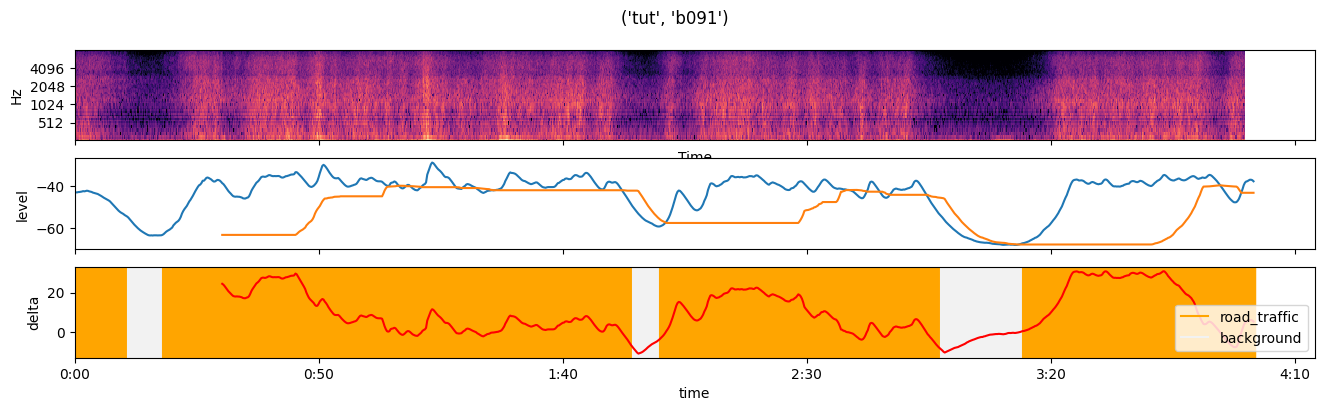

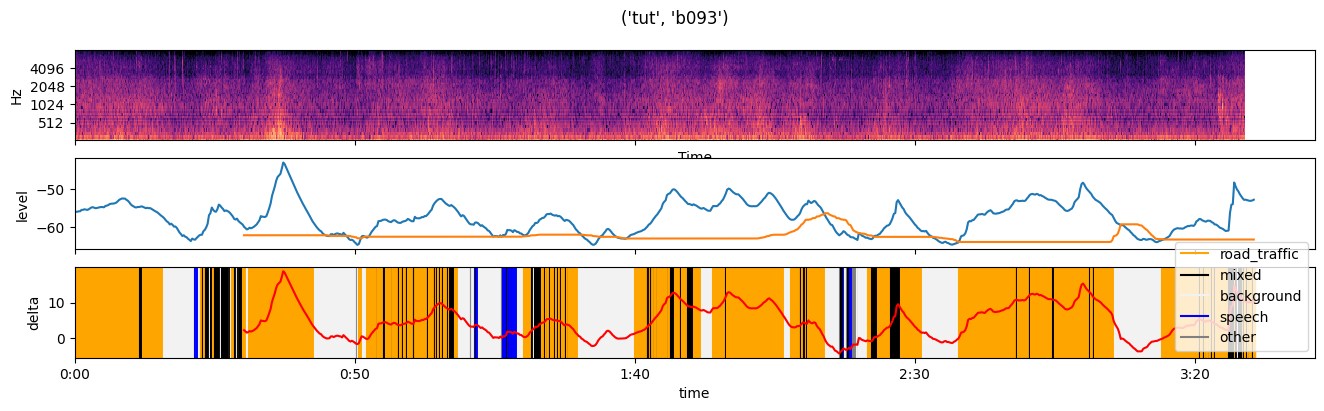

In [70]:

def plot_clip(levels, spec, ann, title=''):

    from src.visualization.events import plot_events, plot_single_track_labels, plot_multitrack_labels
    from src.features.spectrogram import plot_spectrogram
    from src.data.annotations import class_color_map

    aspect = 4.0
    height = 4.0
    width = aspect * height
    fig, (spec_ax, level_ax, label_ax) = plt.subplots(3, figsize=(width, height), sharex=True)

    # spectrogram
    plot_spectrogram(spec_ax, spec)
    
    # soundlevels
    from src.features.soundlevel import compute_background
    ll = compute_background(levels.level, window=30.0)
    ll = ll.reset_index()
    ll['time'] = ll['time'] / pandas.Timedelta(seconds=1)
    seaborn.lineplot(ax=level_ax, data=ll, y='level', x='time')
    seaborn.lineplot(ax=level_ax, data=ll, y='background', x='time')


    # annotations
    classes=all_classes
    time_resolution=0.100

    ann['noise_class'] = ann.annotation.map(m.noise.to_dict()).fillna('unknown')
    last = ann['end'].max()
    multi = make_continious_labels(ann, length=math.ceil(last/time_resolution),
                                 time_resolution=time_resolution,
                                 class_column='noise_class',
                                 classes=classes)

    single = single_track_labels(multi)
    seaborn.lineplot(ax=label_ax, data=ll, y='delta', x='time', color='red')
    plot_single_track_labels(label_ax, single, colors=class_color_map)

    if title:
        fig.suptitle(title)


files = annotations.reset_index().set_index(['dataset', 'clip']).index.unique()
files = files.to_frame()

def plot(row):
    idx = tuple(row)
    l = soundlevels.loc[idx]
    s = spectrograms.loc[idx]
    a = annotations.loc[idx]
    plot_clip(l, s, a, title=str(idx))

files.apply(plot, axis=1)
